You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.<br>
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency.<br>
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.<br>

# Functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [3]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from time_shifted_PID import Histo3D2Dict
from time_shifted_PID import PIfunc
from time_shifted_PID import EqualState
from Spike_Generation import Spike_Time_Generater
from Spike_Generation import NL
from StimulusnResponse import expSnR
from SpatialTemporal_Correlation_and_Convolution import ST_STA

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb
importing Jupyter notebook from StimulusnResponse.ipynb
importing Jupyter notebook from SpatialTemporal_Correlation_and_Convolution.ipynb


# Load Experimental data

## select files and channels

In [84]:
# Fc_list = [0.5,1, 2, 4, 8, 0]
Fc_list = [0.5, 0]
filenames = ['D:\\GoogleDrive\\retina\\Chou\'s data\\MB\\merge\\merge_0727_OUsmooth_Bright_RL_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz' for Fc in Fc_list]
# filenames = ['D:\\GoogleDrive\\retina\\Exps\\2020\\0729\\merge\\merge_0727_OUsmooth_Bright_UL_DR_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz' for Fc in Fc_list]
dt = 1/60
x_list, T_list, rstate_list = expSnR(filenames, dt, 'OLED', [52])
for i in range(len(x_list)):
    rstate_list[i] = rstate_list[i][52-1,:]

In [85]:
# for i in np.arange(1,60):
#     print(i,sum(rstate_list[0][i-1,:]))

# for i in range(len(x_list)):
#     print(i,sum(rstate_list[i]))

In [86]:
Dt = 0.01
x_list = [(x-np.mean(x))/np.std(x) for x in x_list]
v_list = [ndimage.gaussian_filter1d(x, sigma=1, order=1, mode='wrap') / dt  for x in x_list]
# tv_list = [np.append(0, np.diff(x))/dt  for x in x_list]

In [87]:
t_cor_list = []
for i in range(len(x_list)):
    x_cor = np.correlate(x_list[i], x_list[i], "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T_list[i][:len(x_cor)]-dt/2)
    t_cor_list.append( round(np.interp(0.5*max(x_cor),  x_cor, Taxis), 3)) 
t_cor_list

[0.942, 0.631]

In [88]:
#assign states
state_num = 6
xstate_list = [EqualState(x, state_num)[0] for x in x_list]
vstate_list = [EqualState(v, state_num)[0] for v in v_list]
# tvstate_list = [EqualState(tv, state_num)[0] for tv in tv_list]

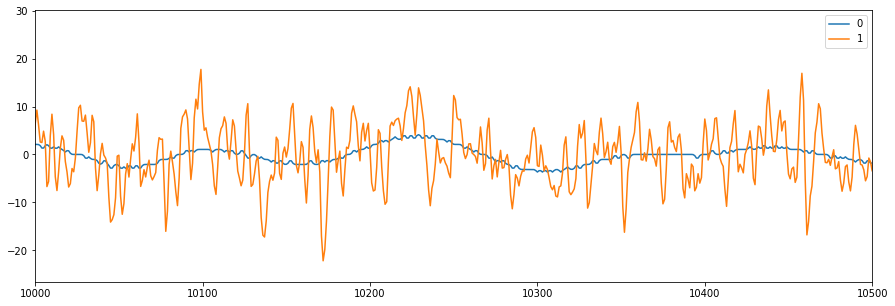

In [89]:
for i in range(len(x_list)):
    plt.plot(v_list[i], label = str(i))
plt.xlim([10000, 10500])
plt.legend()
plt.gcf().set_size_inches(15, 5)

# Real Spike

## STA

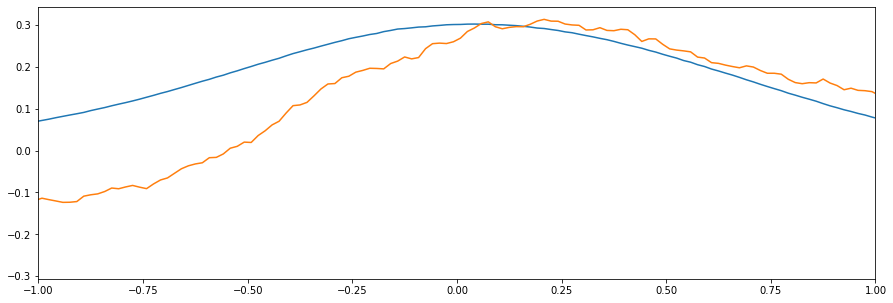

In [90]:
for i in range(len(x_list)):
    plt.plot(T_list[i]-np.mean(T_list[i]), np.correlate(x_list[i], rstate_list[i], 'same')/ np.correlate(np.ones_like(x_list[i]), rstate_list[i], 'same'))
plt.xlim([-1,1])
plt.gcf().set_size_inches(15, 5)

## Plot MI

In [91]:
window = [-1,1] # second
Real_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, Real_Information_list[i] = PIfunc(rstate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = Real_Information_list.copy()

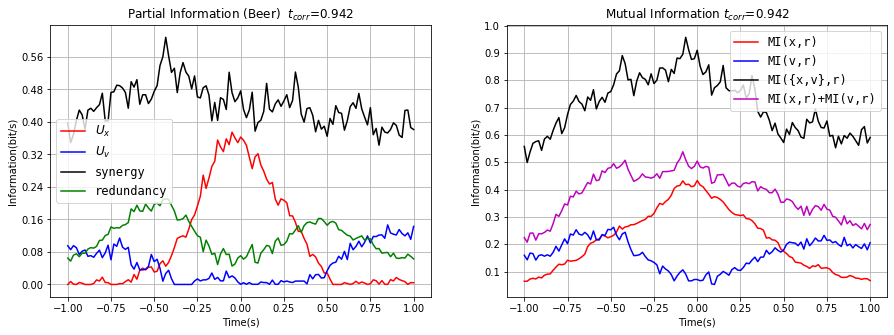

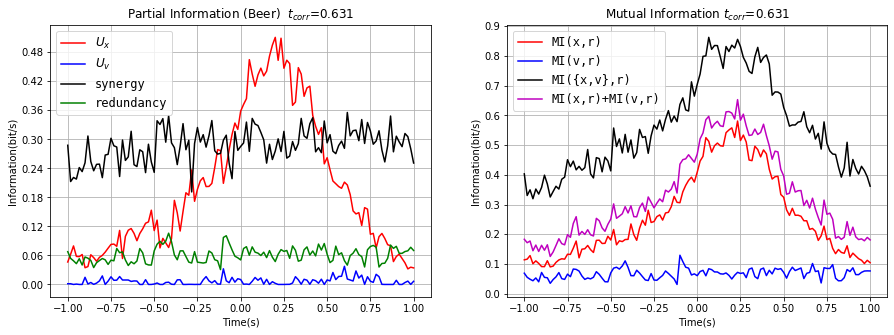

In [92]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

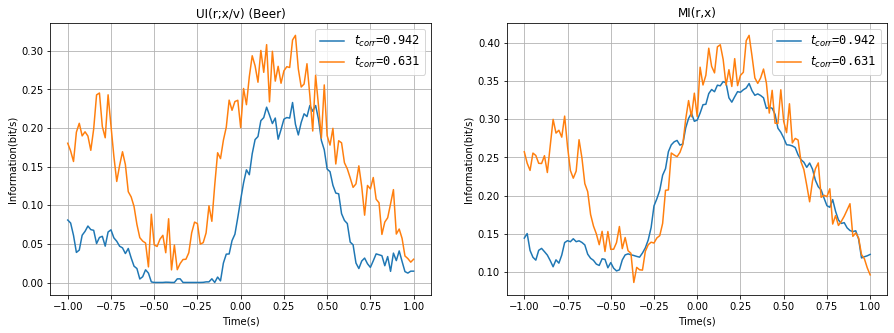

In [36]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

v

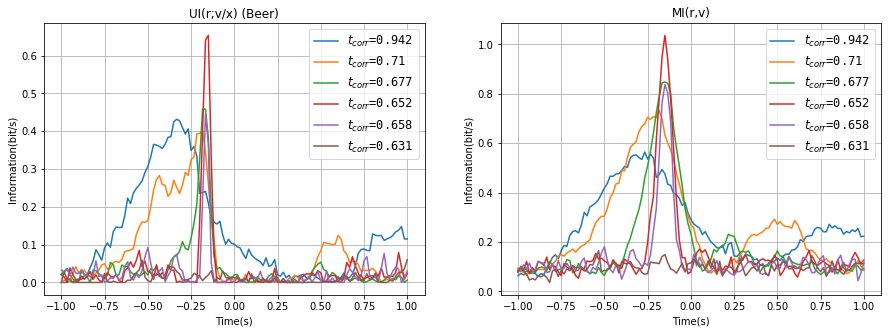

In [29]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;v/x) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,v)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.3, 0.3)
fig.set_size_inches(15, 5)

Synergy and MI(r;{x,v})

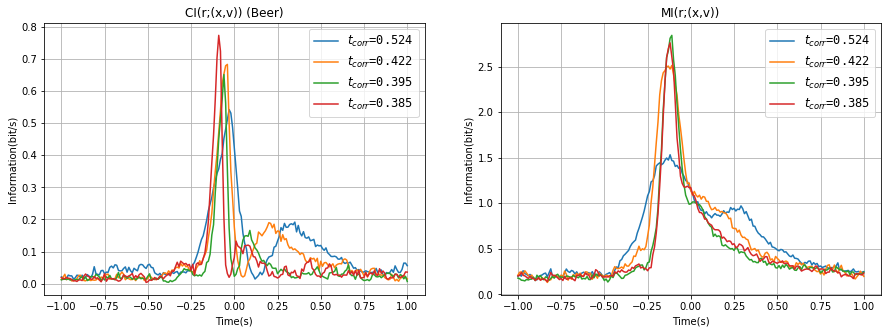

In [91]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','Red')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('CI(r;(x,v)) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r;(x,v))')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.5, 0.2)
fig.set_size_inches(15, 5)

# Matching peak height and $\Delta$

In [30]:
# Delta_list = []
# for i in range(len(x_list)):
# #     loadfiles = np.load('4PID_paper\\lambda vs. PI\\WF_PeakHeights_Fc='+str(Fc_list[i])+'.npz', allow_pickle=True)
#     loadfiles = np.load('4PID_paper\\lambda vs. PI\\WF_PeakHeightnTime_Fc.npz', allow_pickle=True)
#     for k in loadfiles.files:
#         vars()[k] = loadfiles[k][()]
#     Uvox_ratio_table = Uv_peakH/Ux_peakH
#     Uvox_ratio = max(Information_list[i][('Beer','UIv')])/max(Information_list[i][('Beer','UIx')])
#     delta = np.interp(Uvox_ratio, Uvox_ratio_table, Lambdas)
#     Delta_list.append(delta)
# print(Delta_list)
# Lambda_list = []

# loadfiles = np.load('4PID_paper\\beta vs. PI\\PeakHeightnTime vs Fc.npz', allow_pickle=True)
# for k in loadfiles.files:
#     vars()[k] = loadfiles[k][()]
    
# for i in range(len(x_list)-1):
#     Uvox_ratio_table = ndimage.gaussian_filter1d(Uv_peakH_list[i]/Ux_peakH_list[i], sigma=1, mode='reflect')
#     plt.plot(Lambdas, Uvox_ratio_table)
#     Uvox_ratio = max(Information_list[i][('Beer','UIv')])/max(Information_list[i][('Beer','UIx')])
#     Lambda = np.interp(Uvox_ratio, Uvox_ratio_table, Lambdas)
#     plt.scatter(Lambda, Uvox_ratio)
#     Lambda_list.append(Lambda)
# print(Lambda_list)

# Fake Spike - Berry Gain Control

## parameters for LC model and Spike Generator

In [90]:
cSTA = -cSTA

In [103]:
#Gain control function
def gain_func(volt):
    v = volt.copy()
    try: v[v < 0] = 0
    except: 
        if v<0: v=0
    return 1/(1+v**4)
tau = 0.5#sec
B = 10
decay = np.exp(-(np.arange(0,5,dt)+dt)/tau)/tau

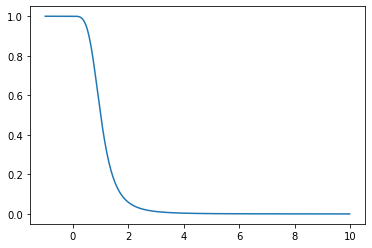

In [104]:
volt = np.arange(-1,10,0.01)
plt.plot(volt,gain_func(volt))

In [105]:
#Assign states
r1state_list = []
ystate_list = [0]*len(x_list)
# Delta_list = [0.4, 0.3, 0.26, 0.24]
# Delta_list = [.9, .9, .9, .9]
FakeSpike_list = [0]*len(x_list)
for j in range(len(x_list)):
    stimulus = x_list[j]*3+10
    sstm = np.zeros_like(stimulus)
    for i in range(len(cSTA)-1):
        for ii in range(i+1):
            sstm[i] += stimulus[ii]*cSTA[i-ii]*dt
    sx = np.convolve(stimulus,cSTA,'valid')*dt
    sstm[len(cSTA)-1:] = sx.copy()
    
    output = np.zeros_like(sstm)
    gain = np.zeros_like(sstm)
    hv = np.zeros_like(sstm)
    dhv = np.zeros_like(sstm)
    for i in np.arange(len(sstm)):
        hv[i] = np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt)
        dhv[i] = dhv[i-1]+(-dhv[i-1]/tau+B*output[i-1]/tau)*dt
        gain[i] = gain_func(dhv[i])
        output[i] = gain[i]*sstm[i]
#     output[output<0] = 0
    


    r = NL(output-np.mean(output), 0)
    ratio = sum(r)/T_list[j][-1]/2
    FakeSpike_list[j] = Spike_Time_Generater(r/ratio, dt, 10)
    ystate_list[j], _ = np.histogram(FakeSpike_list[j], np.append(0,T_list[j]))

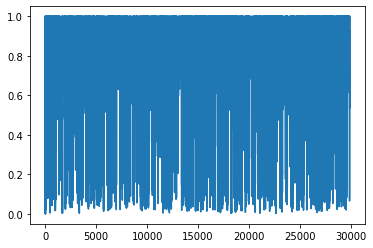

In [106]:
plt.plot(gain)
# plt.plot(hv)
# plt.xlim([14500,15500])

(14500, 15000)

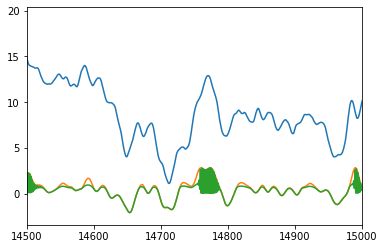

In [109]:
plt.plot(stimulus)
plt.plot(sstm*10)
plt.plot(output*10)
# plt.plot(hv)
plt.xlim([14500,15000])

## Plot MI

In [138]:
window = [-1,1] # second
LC_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, LC_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], tvstate_list[i], dt, window)
Information_list = LC_Information_list.copy()

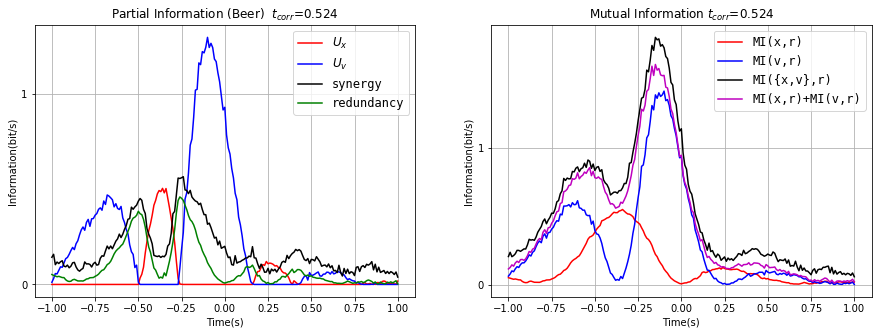

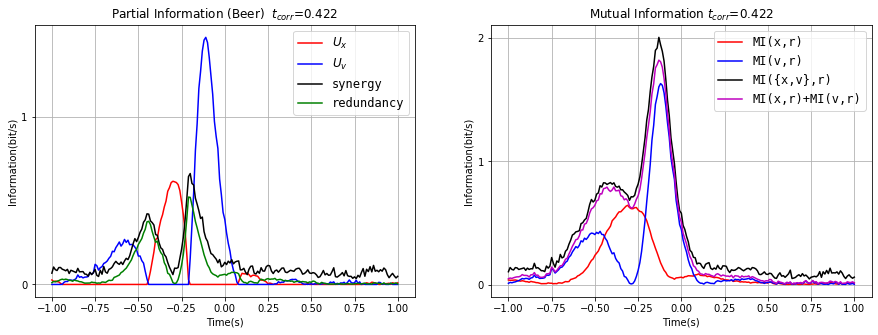

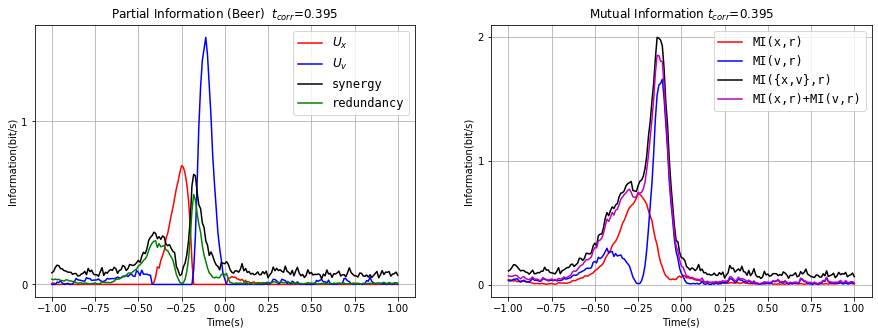

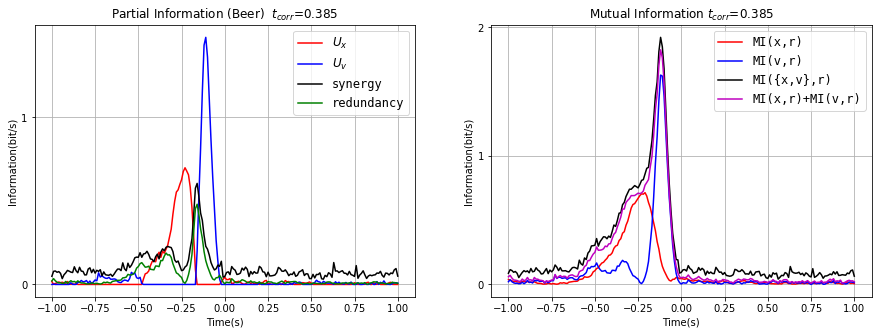

In [139]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

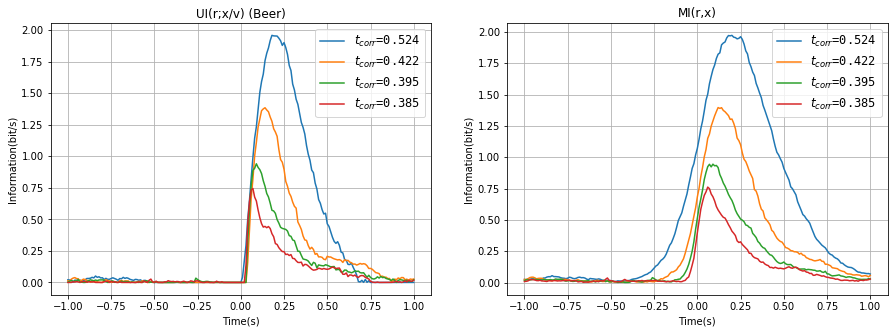

In [16]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

v

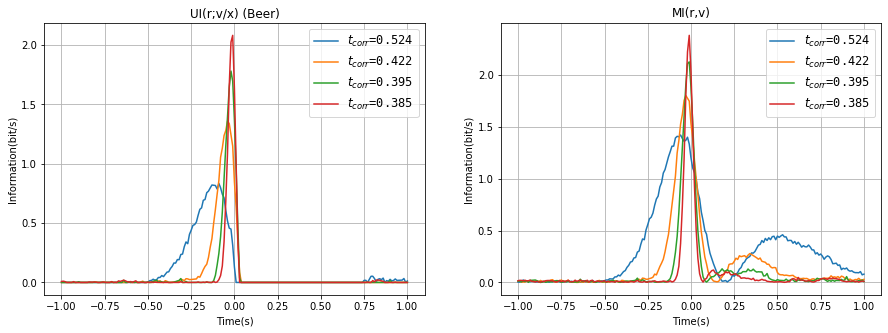

In [17]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;v/x) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,v)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.3, 0.3)
fig.set_size_inches(15, 5)

Synergy and MI(r;{x,v})

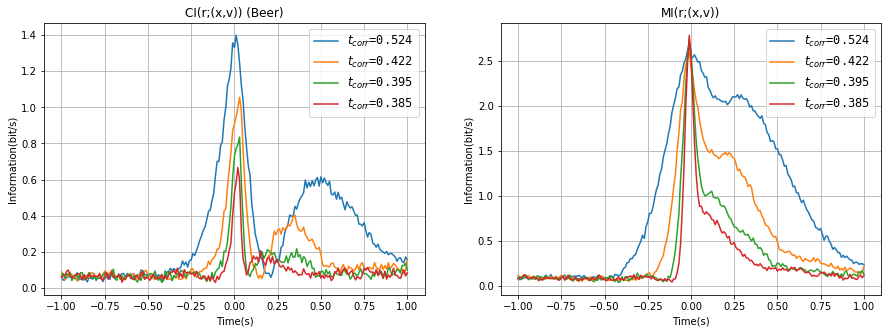

In [18]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('CI(r;(x,v)) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r;(x,v))')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.5, 0.2)
fig.set_size_inches(15, 5)

# Fake Spike - LC model

## parameters for LC model and Spike Generator

In [13]:
#Assign states
r1state_list = []
ystate_list = [0]*len(x_list)
# Delta_list = [0.4, 0.3, 0.26, 0.24]
# Delta_list = [.9, .9, .9, .9]
FakeSpike_list = [0]*len(x_list)
for i in range(len(x_list)):
    Lambda = 0.3
    r1 = (1-Lambda)*x_list[i]+Lambda*v_list[i]

    r = NL(r1-np.mean(r1), 0)
    ratio = sum(r)/T_list[i][-1]/2
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))

## Plot MI

In [14]:
window = [-1,1] # second
LC_Information_list = [0]*len(x_list)
for i in range(len(x_list)):
    timeshift, LC_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], tvstate_list[i], dt, window)
Information_list = LC_Information_list.copy()

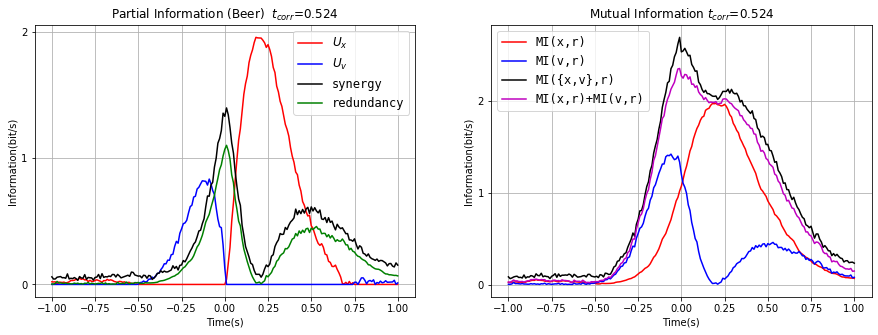

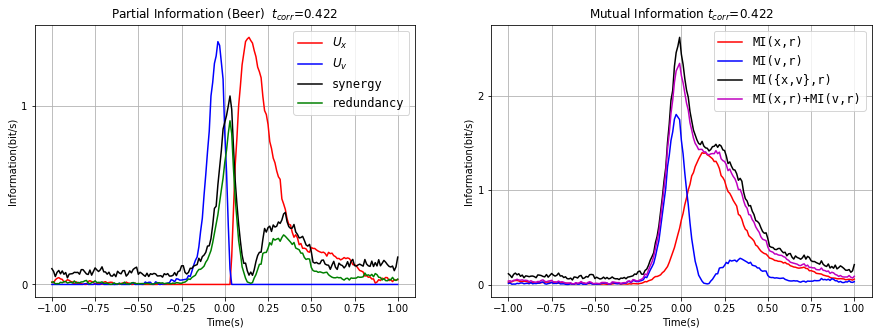

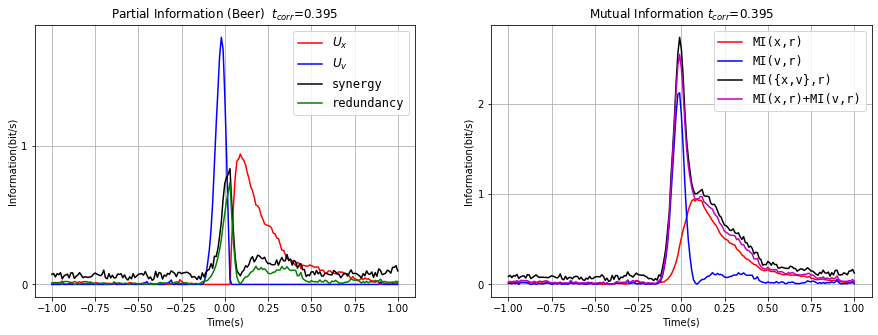

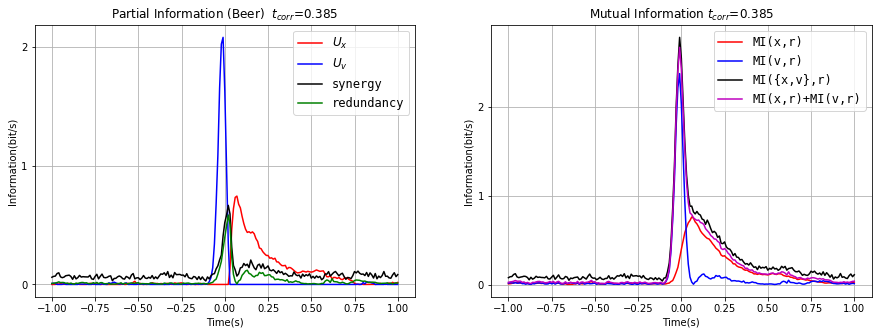

In [15]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

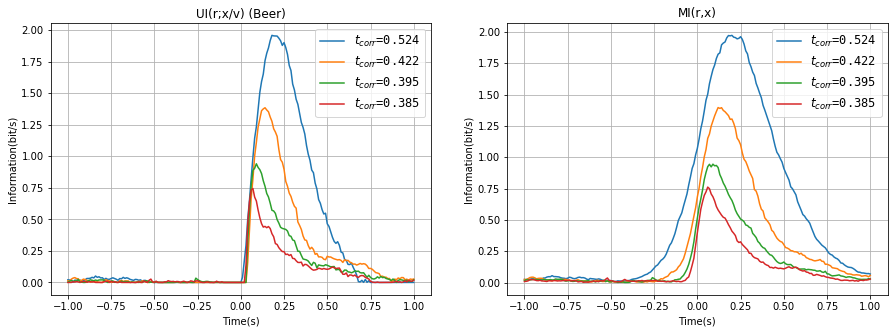

In [16]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

v

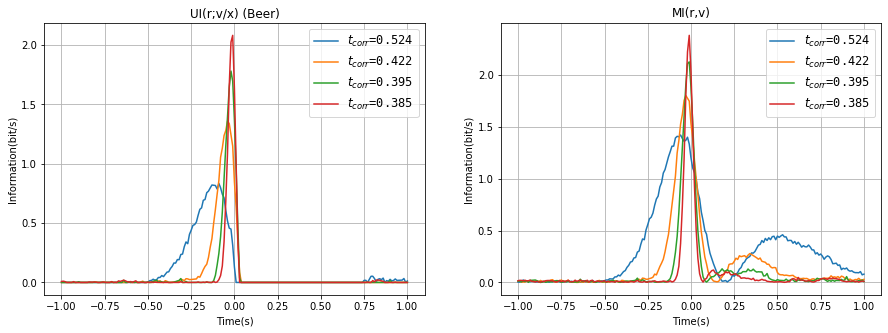

In [17]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;v/x) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,v)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.3, 0.3)
fig.set_size_inches(15, 5)

Synergy and MI(r;{x,v})

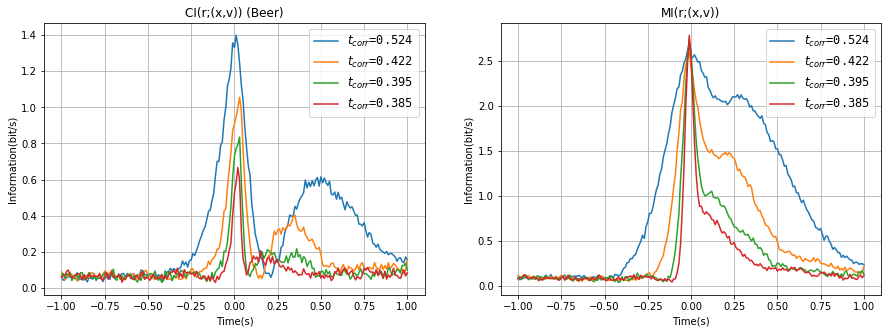

In [18]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(x_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('CI(r;(x,v)) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r;(x,v))')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.5, 0.2)
fig.set_size_inches(15, 5)

# Fake Spike - NGD0D

## parameters for NGD model and Spike generator

In [64]:
#following paremeters match x+v*0.5s
alpha = 20. #1/sec
beta =  2
K = 23.
g = 40.
phi = 1


y_list = []
# Delta_list = [.85, .85, .85, .85]
for i in range(len(x_list)):
    x = x_list[i].copy()
    v = v_list[i].copy()
#     r1 = x_list[i]+Delta_list[i]*v_list[i]
    y=np.zeros(len(T_list[i]))
    z=np.zeros(len(T_list[i]))
    for j in range(len(T_list[i])-1):
        dy=dt*(-alpha*y[j]+K*(x[j]-phi*z[j]))
        dz=dt*(-beta*z[j]+g*y[j])
        noise = K/alpha*np.std(x)*np.random.randn()*0
        y[j+1]=y[j]+dy+noise
        z[j+1]=z[j]+dz
    y_list.append(y.copy())

(15000, 16000)

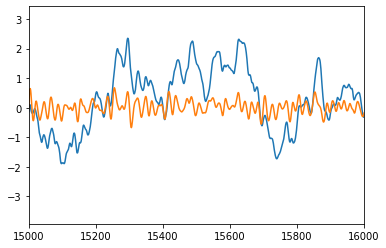

In [65]:
plt.plot(x_list[3])
plt.plot(y_list[3])
plt.xlim([15000, 16000])

Assign states

In [66]:
FakeSpike_list = [0]*len(x_list)
ystate_list = [0]*len(x_list)
time_ystate_list = [0]*len(x_list)
order = np.arange(len(x_list))
np.random.shuffle(order)
print(order)
ratio, theta = 0, 0
for i in order:
    y = y_list[i].copy()
    r = NL(-y+np.mean(y), 0)
    ratio = sum(r)/T_list[i][-1]/2
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     theta = 1.5*np.std(y) if theta == 0 else theta
#     r = NL(np.mean(y)-y, theta)
#     ratio = sum(r)/sum(rstate_list[i]) if ratio == 0 else ratio
#     FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
#     print(len(FakeSpike_list[i])/sum(rstate_list[i]), len(FakeSpike_list[i])/len(r1))
#     ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     Spike = np.hstack((0, FakeSpike_list[i], T_list[i][-1]))
#     counter = 0
#     ty = np.zeros_like(y)
#     for k in range(len(ystate_list[i])):
#         counter += ystate_list[i][k]
#         ty[k] = (Spike[counter+1]-Spike[counter-ystate_list[i][k]])/(ystate_list[i][k]+1)
#     time_ystate_list[i], _ = EqualState(ty, 6)

[0 2 3 1]


## Plot STA

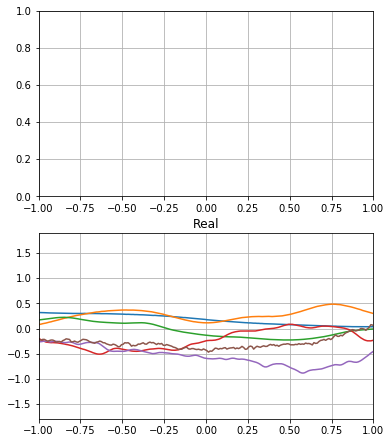

In [52]:
fig, (ax2, ax3) = plt.subplots(2,1)
for i in range(len(x_list)):
#     ax2.plot(T_list[i]-np.mean(T_list[i]), np.correlate(x_list[i], ystate_list[i], 'same')/ np.correlate(np.ones_like(x_list[i]), ystate_list[i], 'same'))
#     ax2.set_title('Fake')
    ax3.plot(T_list[i]-np.mean(T_list[i]), np.correlate(x_list[i], rstate_list[i], 'same')/ np.correlate(np.ones_like(x_list[i]), rstate_list[i], 'same'))
    ax3.set_title('Real')
for ax in (ax2, ax3): 
    ax.set_xlim([-1,1])
    ax.grid()
fig.set_size_inches(6, 7.5)

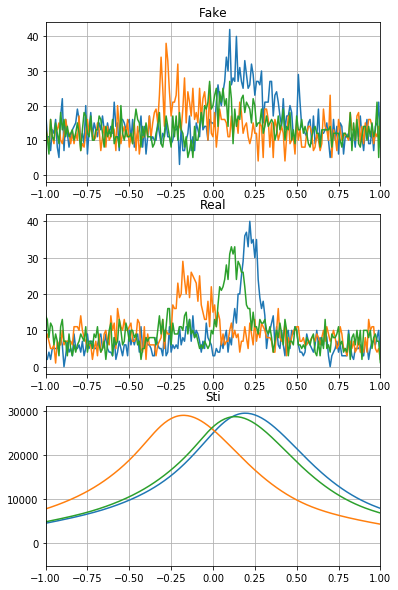

In [92]:
fig, (ax2, ax3, ax4) = plt.subplots(3,1)
for i in [1,2,3]:
    ax2.plot(T_list[i]-np.mean(T_list[i]), np.correlate(ystate_list[0], ystate_list[i], 'same'))
    ax2.set_title('Fake')
    ax3.plot(T_list[i]-np.mean(T_list[i]), np.correlate(rstate_list[0], rstate_list[i], 'same'))
    ax3.set_title('Real')
    ax4.plot(T_list[i]-np.mean(T_list[i]), np.correlate(x_list[0], x_list[i], 'same'))
    ax4.set_title('Sti')
for ax in (ax2, ax3, ax4): 
    ax.set_xlim([-1,1])
    ax.grid()
fig.set_size_inches(6, 10)

(-1, 1)

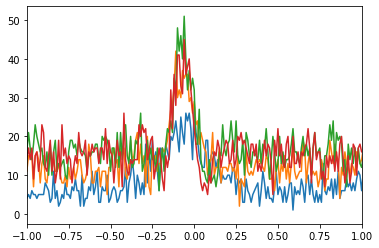

In [83]:
for i in range(len(x_list)):
    plt.plot(T_list[i]-np.mean(T_list[i]), np.correlate(ystate_list[0], rstate_list[i], 'same'))
plt.xlim([-1,1])

(17000, 20000)

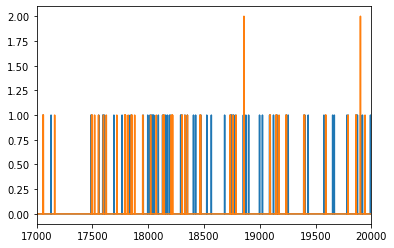

In [97]:
i = 1
stepshift = int(0.5+np.argmax(ndimage.gaussian_filter1d(np.correlate(ystate_list[i], rstate_list[i], 'same'), sigma=5, mode='reflect'))-len(ystate_list[i])/2)
plt.plot(ystate_list[i][:stepshift])
plt.plot(rstate_list[i][-stepshift:])
plt.xlim([17000, 20000])

## Plot MI

In [23]:
window = [-1,1] # second
NGD_Information_list = [0]*len(y_list)
for i in range(len(y_list)):
    timeshift, NGD_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = NGD_Information_list.copy()

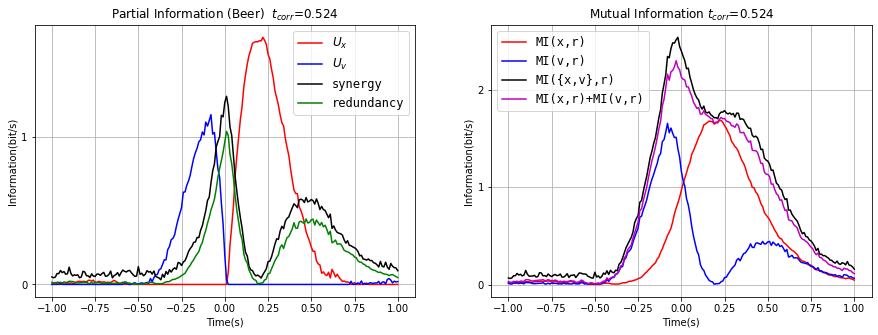

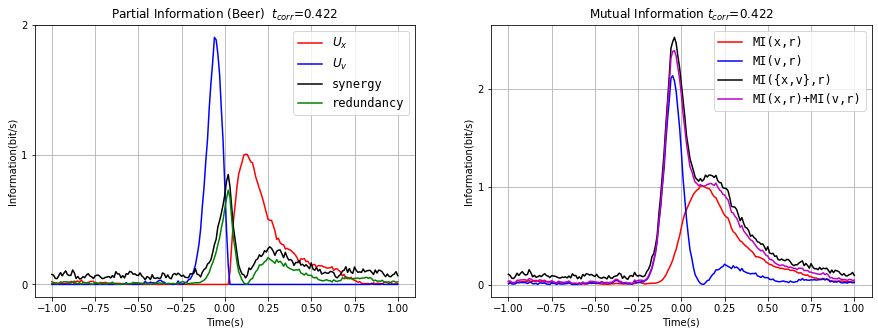

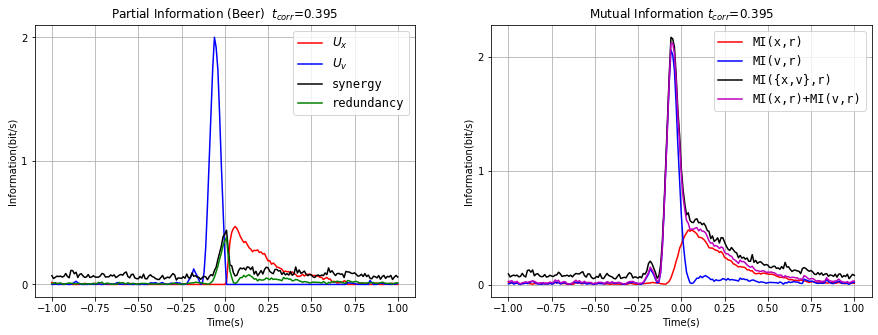

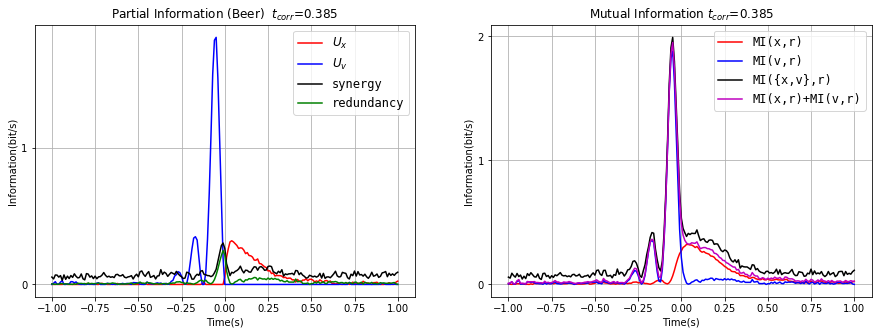

In [24]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

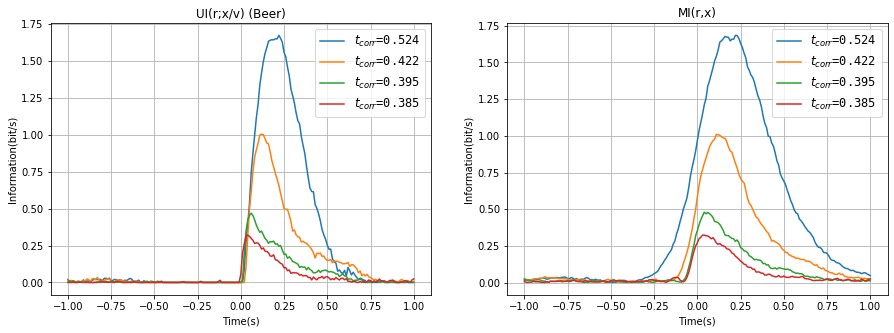

In [25]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(y_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

v

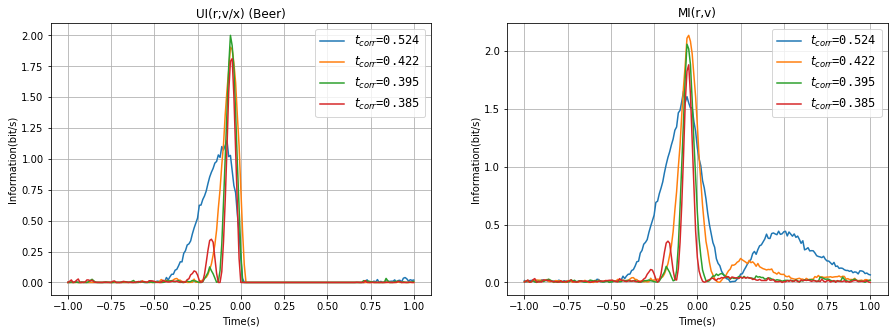

In [26]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(y_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;v/x) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,v)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.3, 0.3)
fig.set_size_inches(15, 5)

Synergy and MI(r;{x,v})

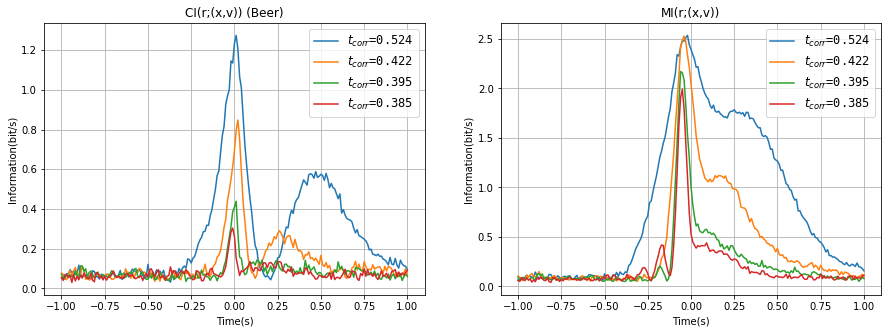

In [27]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(y_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('CI(r;(x,v)) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r;(x,v))')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.5, 0.2)
fig.set_size_inches(15, 5)

# Voss NGD

In [62]:
#following paremeters match x+v*0.5s
alpha = 100 #1/sec
K = 150
tau = 0.15

y_list = []
# Delta_list = [.85, .85, .85, .85]
for i in range(len(x_list)):
    x = x_list[i].copy()
    v = v_list[i].copy()
#     r1 = x_list[i]+Delta_list[i]*v_list[i]
    y=np.zeros(len(T_list[i]))
    z=np.zeros(len(T_list[i]))
    for j in range(len(T_list[i])-1):
        past_step = min(j - int(np.round(tau/dt)), 0)
        dy=dt*(-alpha*y[j]+K*(x[j]-y[past_step]))
        y[j+1]=y[j]+dy
    y_list.append(y.copy())

(15000, 16000)

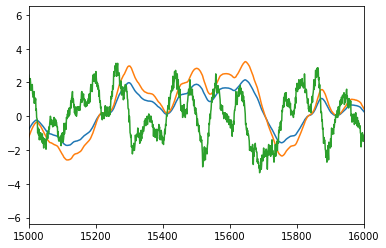

In [63]:
i = 0
plt.plot(x_list[i])
plt.plot(y_list[i])
plt.plot(v_list[i]/np.std(v_list[i])*np.std(y_list[i]))
plt.xlim([15000, 16000])

Assign states

In [58]:
FakeSpike_list = [0]*len(x_list)
ystate_list = [0]*len(x_list)
time_ystate_list = [0]*len(x_list)
order = np.arange(len(x_list))
np.random.shuffle(order)
print(order)
ratio, theta = 0, 0
for i in order:
    y = y_list[i].copy()
    r = NL(y-np.mean(y), 0)
    ratio = sum(r)/T_list[i][-1]/2
    FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
    ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     theta = 1.5*np.std(y) if theta == 0 else theta
#     r = NL(np.mean(y)-y, theta)
#     ratio = sum(r)/sum(rstate_list[i]) if ratio == 0 else ratio
#     FakeSpike_list[i] = Spike_Time_Generater(r/ratio, dt, 10)
#     print(len(FakeSpike_list[i])/sum(rstate_list[i]), len(FakeSpike_list[i])/len(r1))
#     ystate_list[i], _ = np.histogram(FakeSpike_list[i], np.append(0,T_list[i]))
#     Spike = np.hstack((0, FakeSpike_list[i], T_list[i][-1]))
#     counter = 0
#     ty = np.zeros_like(y)
#     for k in range(len(ystate_list[i])):
#         counter += ystate_list[i][k]
#         ty[k] = (Spike[counter+1]-Spike[counter-ystate_list[i][k]])/(ystate_list[i][k]+1)
#     time_ystate_list[i], _ = EqualState(ty, 6)

[1 2 0 3]


## Plot STA

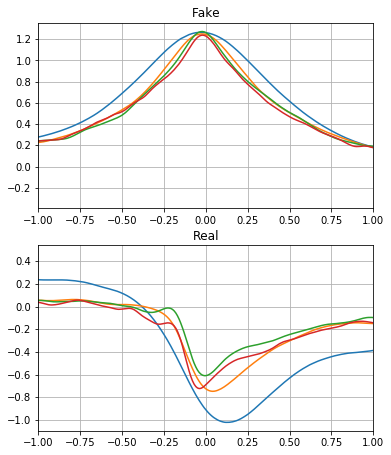

In [59]:
fig, (ax2, ax3) = plt.subplots(2,1)
for i in range(len(x_list)):
    ax2.plot(T_list[i]-np.mean(T_list[i]), np.correlate(x_list[i], ystate_list[i], 'same')/ np.correlate(np.ones_like(x_list[i]), ystate_list[i], 'same'))
    ax2.set_title('Fake')
    ax3.plot(T_list[i]-np.mean(T_list[i]), np.correlate(x_list[i], rstate_list[i], 'same')/ np.correlate(np.ones_like(x_list[i]), rstate_list[i], 'same'))
    ax3.set_title('Real')
for ax in (ax2, ax3): 
    ax.set_xlim([-1,1])
    ax.grid()
fig.set_size_inches(6, 7.5)

## Plot MI

In [49]:
window = [-1,1] # second
NGD_Information_list = [0]*len(y_list)
for i in range(len(y_list)):
    timeshift, NGD_Information_list[i] = PIfunc(ystate_list[i], xstate_list[i], vstate_list[i], dt, window)
Information_list = NGD_Information_list.copy()

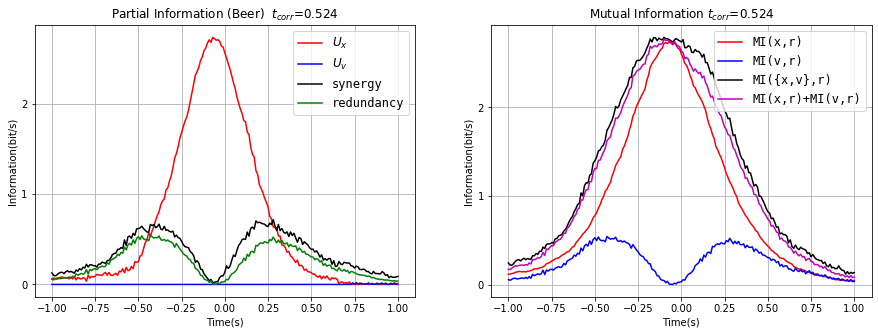

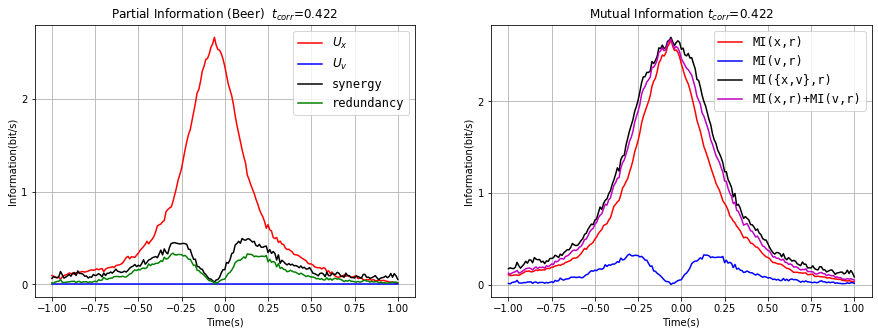

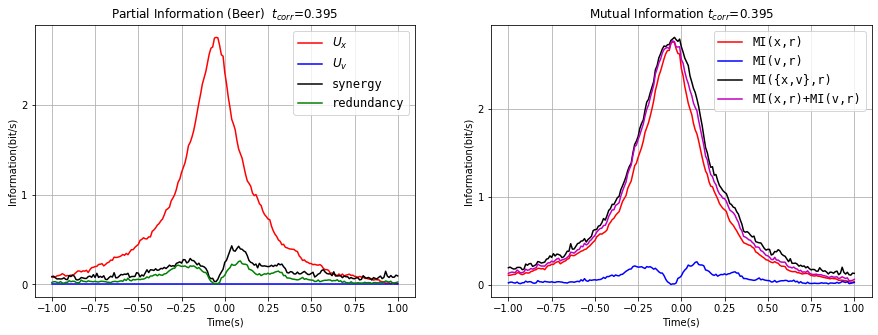

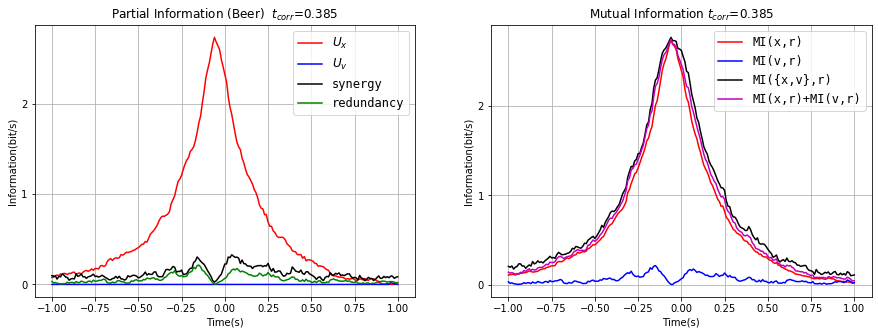

In [50]:
for i in range(len(x_list)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax2.set_title('Partial Information (Beer)  '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time(s)')
    ax2.set_ylabel('Information(bit/s)')
    ax2.legend( (r'$U_x$', r'$U_v$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()
    
    #plot MIs
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')], 'm-')
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax3.set_title('Mutual Information '+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time(s)')
    ax3.set_ylabel('Information(bit/s)')
    ax3.grid()
    ax3.legend( ('MI(x,r)', 'MI(v,r)', 'MI({x,v},r)', 'MI(x,r)+MI(v,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    fig.set_size_inches(15, 5)

x

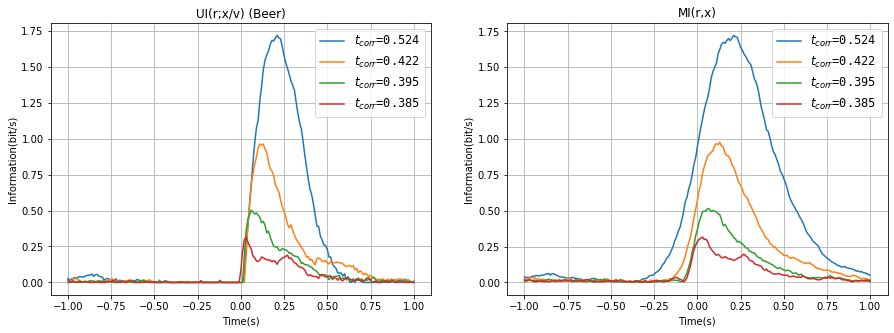

In [34]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(y_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIx')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;x/v) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,x)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
fig.set_size_inches(15, 5)

v

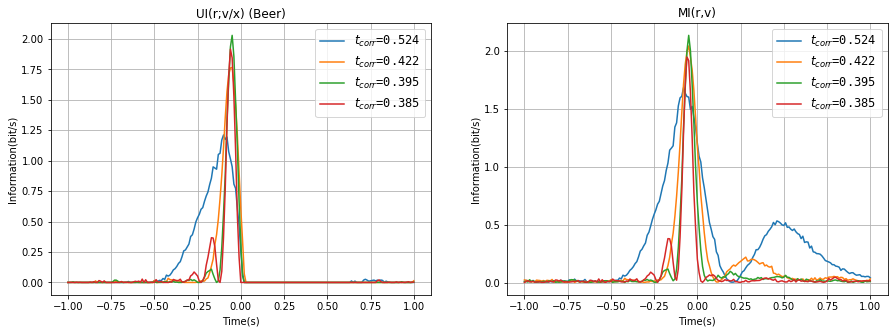

In [35]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(y_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','UIv')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('UI(r;v/x) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r,v)')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.3, 0.3)
fig.set_size_inches(15, 5)

Synergy and MI(r;{x,v})

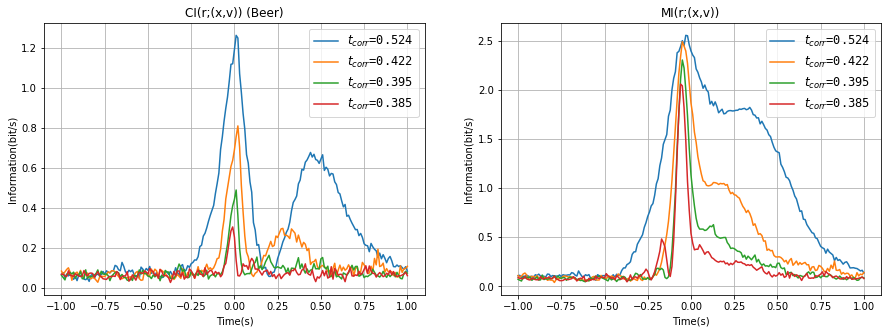

In [36]:
legend_list = []
fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
for i in range(len(y_list)):
    ax2.plot(timeshift,Information_list[i][('Beer','Syn')])
    ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')])
    legend_list.append (r'$t_{corr}$='+str(t_cor_list[i]))
ax2.set_title('CI(r;(x,v)) (Beer)')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Information(bit/s)')
ax3.set_title('MI(r;(x,v))')
ax3.set_xlabel('Time(s)')
ax3.set_ylabel('Information(bit/s)')
ax2.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.legend( legend_list , loc='best', prop={'size': 'large', 'family': 'monospace'})
ax3.grid()
ax2.grid()
# ax2.set_xlim( -0.5, 0.2)
fig.set_size_inches(15, 5)

## Matching peak height and $\Delta$ (of spikes from NGD)

In [37]:
# Delta_list = []
# for i in range(len(x_list)):
#     loadfiles = np.load('4PID_paper\\Delta vs. PI\\WF_PeakHeights_Fc='+str(Fc_list[i])+'.npz', allow_pickle=True)
#     for k in loadfiles.files:
#         vars()[k] = loadfiles[k][()]
#     Uvox_ratio_table = Uv_peakH/Ux_peakH
#     Uvox_ratio = max(Information_list[i][('Beer','UIv')])/max(Information_list[i][('Beer','UIx')])
#     delta = np.interp(Uvox_ratio, Uvox_ratio_table, deltaTs)
#     Delta_list.append(delta)
# print(Delta_list)

# For Paper

In [38]:
# i = 3
# print('Fc=', Fc_list[i])
# fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
# ax2.plot(timeshift,Information_list[i][('Beer','UIx')], 'r-')
# ax2.plot(timeshift,Information_list[i][('Beer','UIv')], 'b-')
# ax2.plot(timeshift,Information_list[i][('Beer','Syn')], 'k-')
# ax2.plot(timeshift,Information_list[i][('Beer','Red')], 'g-')
# ax2.set_title('Partial Information')#+r'$t_{corr}$='+str(t_cor_list[i]))
# ax2.set_xlabel('Time (s)')
# ax2.set_ylabel('Information (bit/s)')
# ax2.legend( (r'$U_x$', r'$U_{\dotx}$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# ax2.grid()

# #plot MIs
# ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')], 'r-')
# ax3.plot(timeshift,Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')], 'b-')
# ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
#          +Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')], 'k-')
# ax3.plot(timeshift,Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]
#          +Information_list[i][('Beer','UIv')], 'm-')
# ax3.set_title('Mutual Information ')#+r'$t_{corr}$='+str(t_cor_list[i]))
# ax3.set_xlabel('Time (s)')
# ax3.set_ylabel('Information (bit/s)')
# ax3.grid()
# ax3.legend( ('I(x,r)', r'I($\dotx$,r)', r'I({x,$\dotx$},r)', r'I(x,r)+I($\dotx$,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
# fig.text(0.06,0.8, '(a)', fontsize = 20)
# fig.set_size_inches(16, 4*(np.sqrt(5)-1))

In [39]:
# fig.savefig('D:\\GoogleDrive\\retina\\PID_paper\\NP_TLPID.jpeg')

In [40]:
# import pandas as pd
# i = 3
# Information_list[i][('timeshift','timeshift')] = timeshift
# Information_list[i][('MI','I(x,r)')] = Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]
# Information_list[i][('MI',r'I($\dotx$,r)')] = Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Red')]
# Information_list[i][('MI',r'I({x,$\dotx$},r)')] = Information_list[i][('Beer','UIx')]+Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]+Information_list[i][('Beer','Syn')]
# Information_list[i][('MI',r'I(x,r)+I($\dotx$,r)')] = Information_list[i][('Beer','UIx')]+2*Information_list[i][('Beer','Red')]+Information_list[i][('Beer','UIv')]
# data_df = pd.DataFrame(Information_list[i])
# # data = np.arange(1,101).reshape((10,10))
# # data_df = pd.DataFrame(data)
 
# # # change the index and column name
# # data_df.columns = ['A','B','C','D','E','F','G','H','I','J']
# # data_df.index = ['a','b','c','d','e','f','g','h','i','j']
 
# # create and writer pd.DataFrame to excel
# name  = 'ModelMIPI_5Hz'
# writer = pd.ExcelWriter('D:\\GoogleDrive\\retina\\PID_paper\\For Origin Plot\\'+name+'.xlsx')
# data_df.to_excel(writer,'page_1',float_format='%.5f') # float_format 控制精度
# writer.save()